In [19]:
# External dependencies

import numpy as np
import matplotlib.pyplot as plt
import pylops
from scipy.linalg import cholesky

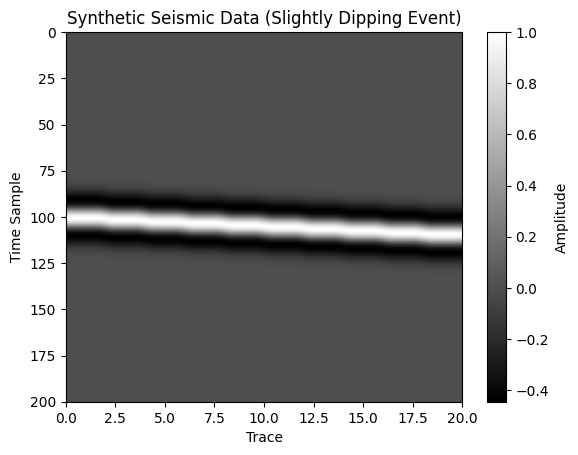

In [23]:
# Seismic event/horizon

# Parameters for the synthetic seismic data
n_rows, n_cols = 200, 20  # Number of rows (time/depth) and columns (trace locations)
dip = 0.5  # Dip of the event in sample points per trace
amplitude = 1  # Amplitude of the event
dt = 0.002
t = np.arange(n_rows) * dt
wav, wavt, wavc = pylops.utils.wavelets.ricker(t[:41], f0=20)  # Ricker wavelet to simulate seismic wavelet

# Synthetic data
seismic_data = np.zeros((n_rows, n_cols))

# Dipping event
event_center = 100
for col in range(n_cols):
    shift = int(dip * col)  # Linear shift due to dipping
    seismic_data[event_center + shift, col] = amplitude

# Convolution with the Ricker wavelet
for col in range(n_cols):
    seismic_data[:, col] = np.convolve(seismic_data[:, col], wav, mode='same')

# Plot
plt.imshow(seismic_data, cmap='gray', aspect='auto', extent=[0, n_cols, n_rows, 0])
plt.title("Synthetic Seismic Data (Slightly Dipping Event)")
plt.xlabel("Trace")
plt.ylabel("Time Sample")
plt.colorbar(label="Amplitude")
plt.show()

4000


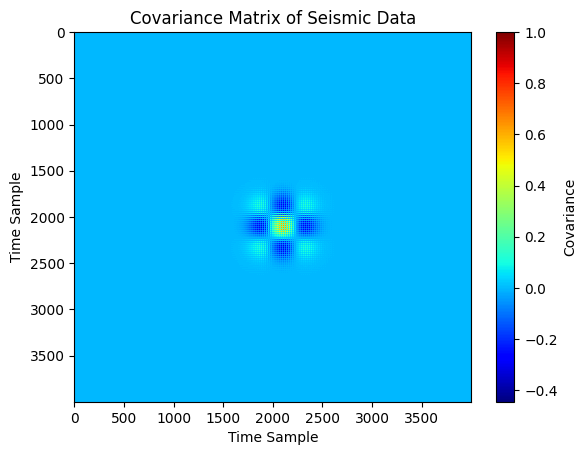

In [24]:
# Extraction of the covariance function from the seismic data

def compute_covariance(data):
    n_rows, n_cols = data.shape
    mean_val = np.mean(data)
    data_centered = data - mean_val
    covariance_matrix = np.zeros((n_rows, n_rows))

    # Compute covariance function for each time sample
    for i in range(n_rows):
        for j in range(n_rows):
            covariance_matrix[i, j] = np.mean(data_centered[i, :] * data_centered[j, :])

    return covariance_matrix

def compute_covariance_2D(data):
    data = data.flatten()
    print(len(data))
    mean_val = np.mean(data)
    data_centered = data - mean_val
    covariance_matrix = np.zeros((len(data), len(data)))

    # Compute covariance function for each time sample
    for i in range(len(data)):
        for j in range(len(data)):
            covariance_matrix[i, j] = np.mean(data_centered[i] * data_centered[j])
    
    return covariance_matrix

# Covariance function from seismic data
covariance_matrix = compute_covariance_2D(seismic_data)

# Plot, covariance matrix
plt.imshow(covariance_matrix, cmap='jet', aspect='auto')
plt.title("Covariance Matrix of Seismic Data")
plt.colorbar(label="Covariance")
plt.xlabel("Time Sample")
plt.ylabel("Time Sample")
plt.show()


In [25]:
covariance_matrix.shape

(4000, 4000)

In [31]:
# Sequential Gaussian simulation function using the covariance matrix
def sequential_gaussian_simulation(covariance_matrix, n_realizations=10, regularization=1e-5):
    n_rows = covariance_matrix.shape[0]
    
    # Add a small value (nugget effect) to the diagonal to ensure positive definiteness
    covariance_matrix += np.eye(n_rows) * regularization
        
    # Perform Cholesky decomposition of the regularized covariance matrix
    L = cholesky(covariance_matrix, lower=True)
    
    # Generate multiple realizations
    realizations = []
    for _ in range(n_realizations):
        z = np.random.normal(0, 1, n_rows)
        realization = np.dot(L, z)
        realizations.append(realization)
    print(np.shape(realizations))
    realizations = np.array(realizations)
    return np.array(realizations.reshape(n_realizations, 200,20))

# Use the same covariance matrix from previous step
covariance_matrix = compute_covariance_2D(seismic_data)

# Realizations of the seismic event
realizations = sequential_gaussian_simulation(covariance_matrix, n_realizations=5, regularization=1e-5)


4000
(5, 4000)


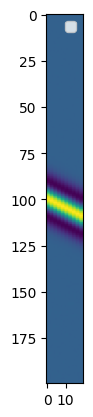

In [32]:
plt.imshow(realizations[3])
plt.legend()

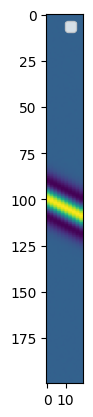

In [33]:
plt.imshow(realizations[4])
plt.legend()

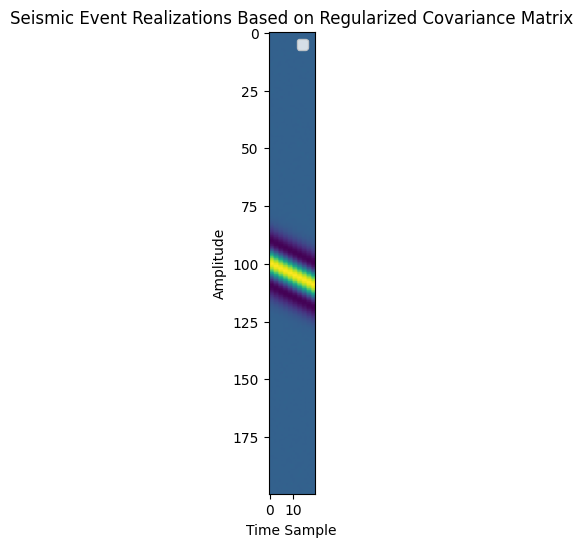

In [34]:

# Check if realizations were generated
if realizations is not None:
    # Plot realizations
    plt.figure(figsize=(10, 6))
    for i, realization in enumerate(realizations):
        plt.imshow(realization, label=f"Realization {i+1}")
    plt.title("Seismic Event Realizations Based on Regularized Covariance Matrix")
    plt.xlabel("Time Sample")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()
else:
    # Give error message
    print("Realizations could not be generated due to a failed Cholesky decomposition.")


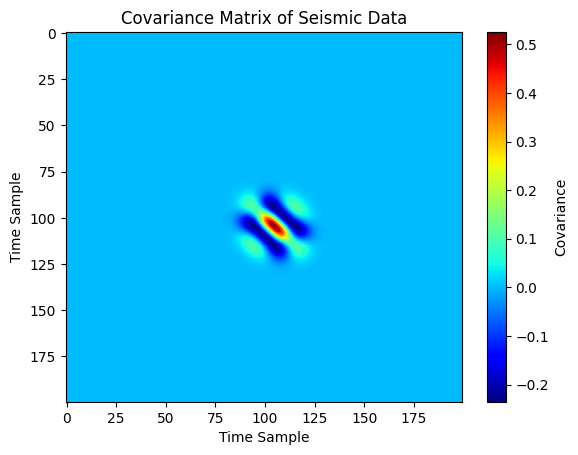

(20, 4000)


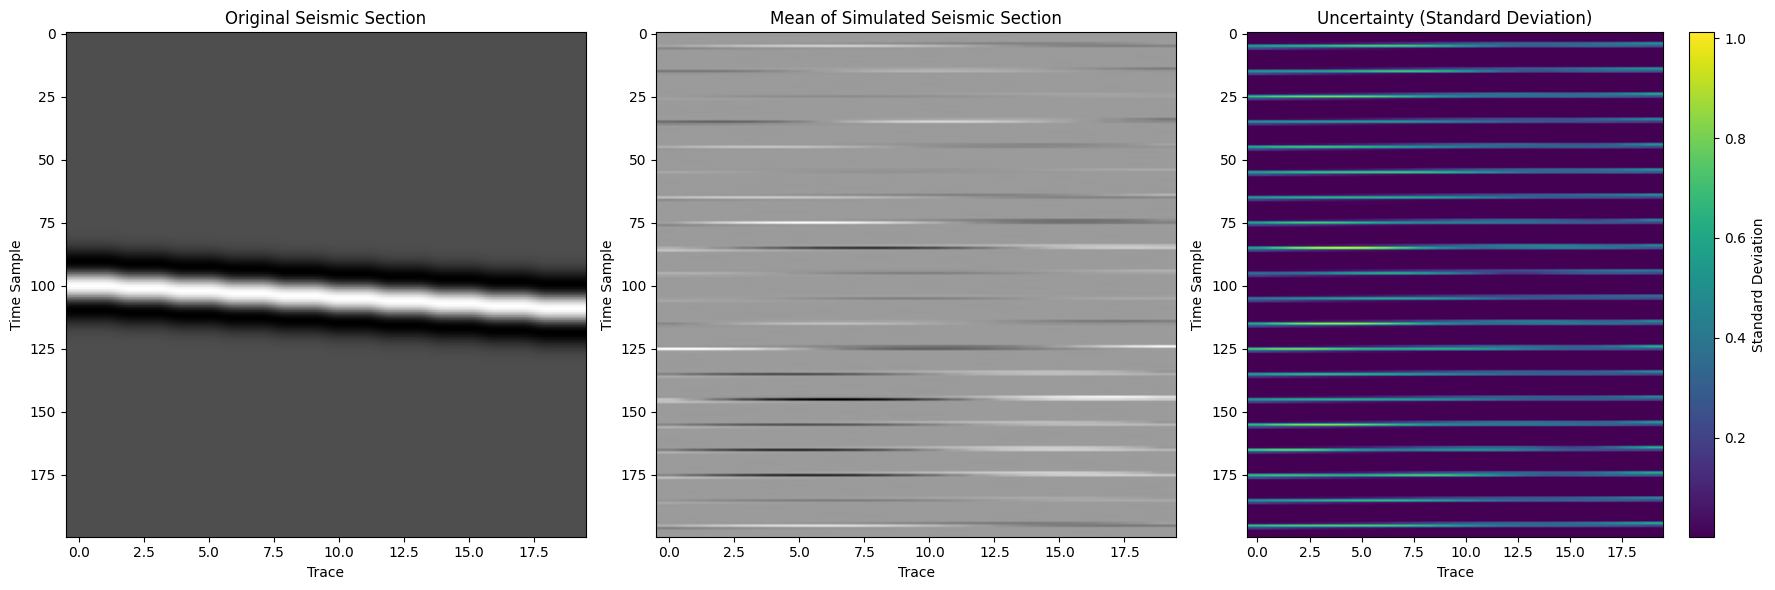

In [35]:
# Sequential Gaussian simulation function for the seismic section, using the covariance matrix

# Covariance function from seismic data

def gaussian_covariance(h, range_param, sill):
    return sill * np.exp(-0.5 * (h / range_param) ** 2)

def compute_covariance(data):
    n_rows, n_cols = data.shape
    mean_val = np.mean(data)
    data_centered = data - mean_val
    covariance_matrix = np.zeros((n_rows, n_rows))
    # Compute covariance function for each time sample
    for i in range(n_rows):
        for j in range(n_rows):
            covariance_matrix[i, j] = np.mean(data_centered[i, :] * data_centered[j, :])

            #h = np.linalg.norm((i*i+j*j)**(1/2))
            #covariance_matrix[i, j] = gaussian_covariance(h, 50, 1)

    return covariance_matrix

# Covariance function from seismic data
covariance_matrix = compute_covariance(seismic_data)

# Plot, covariance matrix
plt.imshow(covariance_matrix, cmap='jet', aspect='auto')
plt.title("Covariance Matrix of Seismic Data")
plt.colorbar(label="Covariance")
plt.xlabel("Time Sample")
plt.ylabel("Time Sample")
plt.show()


# Extend the covariance to all traces by using a block-diagonal matrix (assuming traces are independent)
covariance_matrix_full = np.kron(np.eye(n_cols), covariance_matrix)


# Simulation of the entire seismic section using sequential Gaussian simulation

n_realizations = 20
realizations = sequential_gaussian_simulation(covariance_matrix_full, n_realizations=n_realizations, regularization=1e-5)

if realizations is not None:
    # Reshape realizations to original grid (n_realizations x n_rows x n_cols)
    realizations = realizations.reshape((n_realizations, n_rows, n_cols))
    
    # Mean and standard deviation of the realizations (for uncertainty quantification)
    mean_realization = np.mean(realizations, axis=0)
    std_realization = np.std(realizations, axis=0)
    
    # Plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original seismic section
    axes[0].imshow(seismic_data, aspect='auto', cmap='gray')
    axes[0].set_title('Original Seismic Section')
    axes[0].set_xlabel('Trace')
    axes[0].set_ylabel('Time Sample')
    
    # Mean of the simulated realizations
    axes[1].imshow(mean_realization, aspect='auto', cmap='gray')
    axes[1].set_title('Mean of Simulated Seismic Section')
    axes[1].set_xlabel('Trace')
    axes[1].set_ylabel('Time Sample')
    
    # Standard deviation (uncertainty) of the simulated realizations
    im = axes[2].imshow(std_realization, aspect='auto', cmap='viridis')
    axes[2].set_title('Uncertainty (Standard Deviation)')
    axes[2].set_xlabel('Trace')
    axes[2].set_ylabel('Time Sample')
    fig.colorbar(im, ax=axes[2], label='Standard Deviation')
    
    plt.tight_layout()
    plt.show()
else:
    print("Realizations could not be generated due to a failed Cholesky decomposition.")
